In [1]:
import copy
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
import checkpoint
import torch.nn.utils.prune as prune
from torchvision import transforms

from dataset import MNIST_Dataset, CIFAR10_Dataset
from prune_fns import prune_model
from train import train, train_kd, test, KnowledgeDistill_Loss
import models
from checkpoint import restore_checkpoint

In [2]:
device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")
resnet18 = models.load_resnet18(num_out_class=10, device=device, pretrained=False)

opt = torch.optim.SGD(resnet18.parameters(), lr=0.1, momentum=0.9, weight_decay=0.0001)
scheduler = torch.optim.lr_scheduler.MultiStepLR(opt, [90, 136])
crit = nn.CrossEntropyLoss()
config = {
    'num_epoch' : 180,
    'lr' : 0.001,
    'beta1' : 0.9,
    'batch_size' : 128,
    'ckpt_path' : 'D:/checkpoints/kd_test/resnet18_0/',
    'device' : device,
    'val_freq' : 1000,
    'opt' : opt,
    'crit' : crit,
    'scheduler' : scheduler,
}

In [3]:
dataset = CIFAR10_Dataset(config['batch_size'], dataset_path="./", device=config['device'], val=5000)

In [4]:
def conv_modules(resnet18):
    conv_modules = list()
    conv_modules.append((resnet18.conv1, "weight"))

    for m in (resnet18.layer1, resnet18.layer2, resnet18.layer3, resnet18.layer4):
        for i in range(2):
            conv_modules.append((m[i].conv1, "weight"))
            conv_modules.append((m[i].conv2, "weight"))
            
    return conv_modules

In [ ]:
results = train(config, dataset, resnet18, save_weights_iter=500, params_to_save=conv_modules)

In [ ]:
sd = resnet18.state_dict()

teacher = models.load_resnet18(10, device)
teacher.load_state_dict(sd)

resnet18_kd = models.load_resnet18(10, device)
resnet18_kd.load_state_dict(sd)

weight_init_tensors = dict()
for i, (module, name) in enumerate(conv_modules(resnet18)):
    weight_init = module.weight_init.detach().clone()
    kd_modules = conv_modules(resnet18_kd)
    setattr(kd_modules[i][0], "weight_init", weight_init)
    weight_init_tensors[i] = weight_init

#torch.save(weight_init_tensors, "resnet_kd_init")

In [ ]:
sd = resnet18.state_dict()

teacher = models.load_resnet18(10, device)
teacher.load_state_dict(sd)

resnet18_kd = models.load_resnet18(10, device)
resnet18_kd.load_state_dict(sd)

weight_init_tensors = torch.load("resnet_kd_init")
for i, (module, name) in enumerate(conv_modules(resnet18)):
    kd_modules = conv_modules(resnet18_kd)

    setattr(kd_modules[i][0], "weight_init", weight_init_tensors[i].clone())
    setattr(module, "weight_init", weight_init_tensors[i].clone())



In [ ]:
config['crit_teacher'] = KnowledgeDistill_Loss(teacher, alpha=0)
config['num_epoch'] = 180

prune_model(resnet18_kd, 0.2, conv_modules, device)
prune_model(resnet18, 0.2, conv_modules, device)

config['opt'] = torch.optim.SGD(resnet18_kd.parameters(), lr=0.1, momentum=0.9, weight_decay=0.0001)
config['scheduler'] = torch.optim.lr_scheduler.MultiStepLR(opt, [90, 136])
config['ckpt_path'] = 'D:/checkpoints/kd_test/resnet18_kd_2/'
results2 = train_kd(config, dataset, resnet18_kd, save_weights_iter=500, params_to_save=conv_modules)

In [ ]:
config['num_epoch'] = 180
config['crit_teacher'] = KnowledgeDistill_Loss(teacher, alpha=0.5)
results2 = train_kd(config, dataset, resnet18_kd, save_weights_iter=500, params_to_save=conv_modules)

In [ ]:
config['num_epoch'] = 80

config['opt'] = torch.optim.SGD(resnet18.parameters(), lr=0.1, momentum=0.9, weight_decay=0.0001)
config['scheduler'] = torch.optim.lr_scheduler.MultiStepLR(opt, [90, 136])
config['ckpt_path'] = 'D:/checkpoints/kd_test/resnet18_1/'

results1 = train(config, dataset, resnet18, save_weights_iter=500, params_to_save=conv_modules)

In [9]:
# Load data to plot results:
config['num_epoch'] = 80
config['crit_teacher'] = None

weight_init_tensors = torch.load("resnet_kd_init")
for i, (module, name) in enumerate(conv_modules(resnet18)):
    setattr(module, "weight_init", weight_init_tensors[i].clone())

prune_model(resnet18, 0.0, conv_modules, device)
# alpha=1
config['ckpt_path'] = 'D:/checkpoints/kd_test/resnet18_1/'
results1 = train(config, dataset, resnet18, save_weights_iter=500, params_to_save=conv_modules)

# alpha=0.5
config['ckpt_path'] = 'D:/checkpoints/kd_test/resnet18_kd_1'
results2 = train_kd(config, dataset, resnet18, save_weights_iter=500, params_to_save=conv_modules)

# alpha=0
config['ckpt_path'] = 'D:/checkpoints/kd_test/resnet18_kd_2/'
results3 = train_kd(config, dataset, resnet18, save_weights_iter=500, params_to_save=conv_modules)

Which epoch to load from? Choose from epochs below:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80]
Enter 0 to train from scratch.
>> 

 80


Loading from checkpoint D:/checkpoints/kd_test/resnet18_1/epoch=80.checkpoint.pth.tar
=> Successfully restored checkpoint (trained for 80 epochs)
Which epoch to load from? Choose from epochs below:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83]
Enter 0 to train from scratch.
>> 

 80


Loading from checkpoint D:/checkpoints/kd_test/resnet18_kd_1\epoch=80.checkpoint.pth.tar
=> Successfully restored checkpoint (trained for 80 epochs)
Which epoch to load from? Choose from epochs below:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112]
Enter 0 to train from scratch.
>> 

 80


Loading from checkpoint D:/checkpoints/kd_test/resnet18_kd_2/epoch=80.checkpoint.pth.tar
=> Successfully restored checkpoint (trained for 80 epochs)


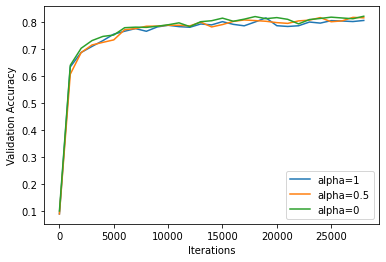

In [37]:
import matplotlib.pyplot as plt

itr = results1[3]
plt.plot(itr, results1[2])
plt.plot(itr, results2[2])
plt.plot(itr, results3[2])
plt.legend(["alpha=1", "alpha=0.5", "alpha=0"])
plt.xlabel("Iterations")
plt.ylabel("Validation Accuracy")
plt.show()

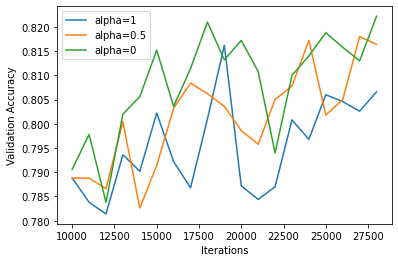

In [38]:
itr = results1[3][10:]
plt.plot(itr, results1[2][10:])
plt.plot(itr, results2[2][10:])
plt.plot(itr, results3[2][10:])
plt.legend(["alpha=1", "alpha=0.5", "alpha=0"])
plt.xlabel("Iterations")
plt.ylabel("Validation Accuracy")
plt.show()

In [47]:
results1[2][-1], results2[2][-1], results3[2][-1]

(0.8066, 0.8164, 0.8222)

In [48]:
len(results1[2])

29